# Machine Learning and Content Analytics - AUEB

## Detecting Heavy Drinking Episodes Using Accelerometer Data

* Konstantopoulou Marianna | p2822122
* Zafeiropoulou Maria | p2822113

## 1. Data Preprocessing

### Import Modules

In [ ]:
#pip install tensorflow

In [1]:
import csv
import numpy as np 
import pandas as pd
import statistics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Flatten, Dense, Dropout
import scipy.stats as stats
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras import layers

### Load Accelerometer Dataset

In [2]:
# Load The full Dataset
acc_data = pd.read_csv("all_accelerometer_data_pids_13.csv")

pid = list(set(acc_data['pid']))

# Create a .csv for every different "pid" code
for i in pid:
    df = acc_data.loc[acc_data['pid'] == i]
    df.to_csv(i, encoding='utf-8')
    print(str(i)+".csv created")
    
# Load Accelerometer Data .csv file for the choosen pid
acc_data = pd.read_csv("MJ8002" ) 

# Transform to Dataframe
acc_data = pd.DataFrame(acc_data)
acc_data.drop("Unnamed: 0", axis=1, inplace=True)
acc_data.head()

SA0297.csv created
MC7070.csv created
JB3156.csv created
BK7610.csv created
PC6771.csv created
DC6359.csv created
JR8022.csv created
DK3500.csv created
HV0618.csv created
SF3079.csv created
CC6740.csv created
BU4707.csv created
MJ8002.csv created


,time,pid,x,y,z
0,1493736949591,MJ8002,0.0025,0.0043,-0.0027
1,1493736949616,MJ8002,-0.0003,-0.0013,-0.0051
2,1493736949641,MJ8002,0.0022,0.0014,-0.0027
3,1493736949665,MJ8002,0.0006,-0.0010,-0.0047
4,1493736949691,MJ8002,0.0009,-0.0005,-0.0055


Add a column with seconds in the Accelerometer Dataset

In [3]:
# "seconds" Function transforms milliseconds to seconds
def seconds(time):
    s = (time/1000) 
    return int(s)

# Add a column with seconds to the Accelerometer Dataset
acc_data['time_seconds'] = acc_data['time'].apply(seconds)
acc_data.head()

,time,pid,x,y,z,time_seconds
0,1493736949591,MJ8002,0.0025,0.0043,-0.0027,1493736949
1,1493736949616,MJ8002,-0.0003,-0.0013,-0.0051,1493736949
2,1493736949641,MJ8002,0.0022,0.0014,-0.0027,1493736949
3,1493736949665,MJ8002,0.0006,-0.0010,-0.0047,1493736949
4,1493736949691,MJ8002,0.0009,-0.0005,-0.0055,1493736949


### Load TAC Dataset

In [4]:
# Load Tac Data .csv file for the choosen "pid"
tac_data = pd.read_csv('MJ8002_clean_TAC.csv')

# Transform to Dataframe
tac_data = pd.DataFrame(tac_data)
tac_data.head()

,timestamp,TAC_Reading
0,1493720054,-0.001385
1,1493721878,0.000864
2,1493722199,0.001913
3,1493722520,0.001333
4,1493722842,-0.000256


### Combine the two datasets (Accelerometer & TAC)

In [5]:
# Columns of the combined dataset
dataset = pd.DataFrame(columns=['pid', 'tac_start', 'tac_end', 'tac', 
                                  'acc_time', 'x', 'y', 'z', 'acc_seconds'])

In [6]:
tac_timestamp = tac_data['timestamp'].to_list() 
tac_reading = tac_data['TAC_Reading'].to_list() 

In [7]:
# Combine the two dataframes based on tac time intervals 

x = (len(tac_timestamp) - 1)

for j in range(0, x):
    
    start = tac_timestamp[j] # ex. 1493720054 | 1rst row
    end = tac_timestamp[j+1] # ex. 1493721878 | 2nd row
    
    try:
        # check if timestamp value exists in start-end range and 
        # use "cr" value for sublisting 
        cr = acc_data['time_seconds'].between(start, end, inclusive='neither')
        cr.to_list().index(True)
        acc_data2 = acc_data
        acc_data2['includes'] = cr
        acc_data2 = acc_data2.loc[acc_data2['includes'] == True]

        acc_data2 = acc_data2.assign(tac_start_2 = start)
        acc_data2 = acc_data2.assign(tac_end_2 = end)
        acc_data2 = acc_data2.assign(tac = tac_reading[j])
        
        # Create the combined dataset
        data2 = pd.DataFrame()
        data2['pid'] = acc_data2['pid']
        data2['tac_start'] = acc_data2['tac_start_2']
        data2['tac_end'] = acc_data2['tac_start_2']
        data2['tac'] = acc_data2['tac']
        data2['acc_time'] = acc_data2['time']
        data2['x'] = acc_data2['x']
        data2['y'] = acc_data2['y']
        data2['z'] = acc_data2['z']
        data2['acc_seconds'] = acc_data2['time'].apply(seconds)
        
        dataset = pd.concat(objs=[dataset, data2])

    except:
        pass
    
dataset

,pid,tac_start,tac_end,tac,acc_time,x,y,z,acc_seconds
0,MJ8002,1493736009,1493736009,0.00115,1493736949591,0.0025,0.0043,-0.0027,1493736949
1,MJ8002,1493736009,1493736009,0.00115,1493736949616,-0.0003,-0.0013,-0.0051,1493736949
2,MJ8002,1493736009,1493736009,0.00115,1493736949641,0.0022,0.0014,-0.0027,1493736949
3,MJ8002,1493736009,1493736009,0.00115,1493736949665,0.0006,-0.001,-0.0047,1493736949
4,MJ8002,1493736009,1493736009,0.00115,1493736949691,0.0009,-0.0005,-0.0055,1493736949
...,...,...,...,...,...,...,...,...,...
631298,MJ8002,1493783820,1493783820,0.040976,1493784951889,0.0011,0.0023,-0.0045,1493784951
631299,MJ8002,1493783820,1493783820,0.040976,1493784951911,0.0001,-0.0015,-0.0053,1493784951
631300,MJ8002,1493783820,1493783820,0.040976,1493784951935,0.0,-0.0015,-0.0046,1493784951
631301,MJ8002,1493783820,1493783820,0.040976,1493784951961,0.0014,-0.0026,-0.0044,1493784951


### Make some further dataset transformations

Classify - Change the "tac" values based on threshold (0.08)

In [8]:
# Function "threshold" used for classification based on 0.08 theshold value
def threshold(d):
    # tac value below 0.08 not drunk
    if d < 0.08: 
        return 0
    else:
    # else drunk
        return 1
    
# "tac" classification using "theshold" function
dataset['tac'] = dataset['tac'].apply(threshold)
dataset.head()

,pid,tac_start,tac_end,tac,acc_time,x,y,z,acc_seconds
0,MJ8002,1493736009,1493736009,0,1493736949591,0.0025,0.0043,-0.0027,1493736949
1,MJ8002,1493736009,1493736009,0,1493736949616,-0.0003,-0.0013,-0.0051,1493736949
2,MJ8002,1493736009,1493736009,0,1493736949641,0.0022,0.0014,-0.0027,1493736949
3,MJ8002,1493736009,1493736009,0,1493736949665,0.0006,-0.001,-0.0047,1493736949
4,MJ8002,1493736009,1493736009,0,1493736949691,0.0009,-0.0005,-0.0055,1493736949


Pick only the 20 first instances of accelerometer readings of every second

In [9]:
# Find unique acceleromete seconds
uniq = dataset['acc_seconds'].unique()

In [10]:
vc = dataset['acc_seconds'].value_counts()

In [11]:
min(vc), max(vc)

(1, 42)

In [12]:
dataset1 = pd.DataFrame(columns=['pid', 'tac_start', 'tac_end', 'tac', 
                                  'acc_time', 'x', 'y', 'z', 'acc_seconds'])

In [13]:
for i in uniq:
    p = dataset.loc[dataset['acc_seconds'] == i]
    # pick 20 first accelerometer second instances
    inc = p.head(20) 
    dataset1 = pd.concat(objs=[dataset1, inc])
    
dataset1

,pid,tac_start,tac_end,tac,acc_time,x,y,z,acc_seconds
0,MJ8002,1493736009,1493736009,0,1493736949591,0.0025,0.0043,-0.0027,1493736949
1,MJ8002,1493736009,1493736009,0,1493736949616,-0.0003,-0.0013,-0.0051,1493736949
2,MJ8002,1493736009,1493736009,0,1493736949641,0.0022,0.0014,-0.0027,1493736949
3,MJ8002,1493736009,1493736009,0,1493736949665,0.0006,-0.001,-0.0047,1493736949
4,MJ8002,1493736009,1493736009,0,1493736949691,0.0009,-0.0005,-0.0055,1493736949
...,...,...,...,...,...,...,...,...,...
631278,MJ8002,1493783820,1493783820,0,1493784951385,0.0011,0.0003,-0.0037,1493784951
631279,MJ8002,1493783820,1493783820,0,1493784951411,-0.0024,-0.0013,-0.0062,1493784951
631280,MJ8002,1493783820,1493783820,0,1493784951436,0.0,-0.0016,-0.0048,1493784951
631281,MJ8002,1493783820,1493783820,0,1493784951462,0.0,-0.0008,-0.0041,1493784951


Create a copy of the Dataset and drop unwanted columns

In [14]:
dataset_copy = dataset1.copy()
dataset_copy = pd.DataFrame(dataset_copy)
dataset_copy.head()

,pid,tac_start,tac_end,tac,acc_time,x,y,z,acc_seconds
0,MJ8002,1493736009,1493736009,0,1493736949591,0.0025,0.0043,-0.0027,1493736949
1,MJ8002,1493736009,1493736009,0,1493736949616,-0.0003,-0.0013,-0.0051,1493736949
2,MJ8002,1493736009,1493736009,0,1493736949641,0.0022,0.0014,-0.0027,1493736949
3,MJ8002,1493736009,1493736009,0,1493736949665,0.0006,-0.001,-0.0047,1493736949
4,MJ8002,1493736009,1493736009,0,1493736949691,0.0009,-0.0005,-0.0055,1493736949


In [15]:
dataset1.drop("pid", axis=1, inplace=True)
dataset1.drop("tac_start", axis=1, inplace=True)
dataset1.drop("tac_end", axis=1, inplace=True)
dataset1.drop("acc_seconds", axis=1, inplace=True)

dataset1.head()

,tac,acc_time,x,y,z
0,0,1493736949591,0.0025,0.0043,-0.0027
1,0,1493736949616,-0.0003,-0.0013,-0.0051
2,0,1493736949641,0.0022,0.0014,-0.0027
3,0,1493736949665,0.0006,-0.001,-0.0047
4,0,1493736949691,0.0009,-0.0005,-0.0055


Classify to Drunk and not Drunk, keep the same number of rows and finally combine the two dataframes

In [16]:
dr = dataset1.loc[dataset1['tac'] == 1]
dr.head()

,tac,acc_time,x,y,z
150650,1,1493746992001,-0.0008,-0.0004,-0.0028
150651,1,1493746992027,0.0017,-0.0005,-0.003
150652,1,1493746992052,-0.0011,-0.0001,-0.0021
150653,1,1493746992077,-0.0001,-0.0004,-0.0019
150654,1,1493746992107,0.0017,0.0011,-0.0043


In [17]:
n_dr = dataset1.loc[dataset1['tac'] == 0]
n_dr.head()

,tac,acc_time,x,y,z
0,0,1493736949591,0.0025,0.0043,-0.0027
1,0,1493736949616,-0.0003,-0.0013,-0.0051
2,0,1493736949641,0.0022,0.0014,-0.0027
3,0,1493736949665,0.0006,-0.001,-0.0047
4,0,1493736949691,0.0009,-0.0005,-0.0055


In [18]:
dr.shape, n_dr.shape

((96392, 5), (219299, 5))

In [19]:
# find the min size of the two dataframes to reshape accordingly
min_size = min(len(dr.index), len(n_dr.index)) 
dr = dr.head(min_size)
n_dr = n_dr.head(min_size)

In [20]:
dr.shape == n_dr.shape

True

In [21]:
# Finally, combine the two dataframes
data = pd.concat(objs=[n_dr, dr])
data.head()

,tac,acc_time,x,y,z
0,0,1493736949591,0.0025,0.0043,-0.0027
1,0,1493736949616,-0.0003,-0.0013,-0.0051
2,0,1493736949641,0.0022,0.0014,-0.0027
3,0,1493736949665,0.0006,-0.001,-0.0047
4,0,1493736949691,0.0009,-0.0005,-0.0055


In [22]:
# Check for nulls

data.isnull().sum()

tac         0
acc_time    0
x           0
y           0
z           0
dtype: int64

In [23]:
# Data Information

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192784 entries, 0 to 488454
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   tac       192784 non-null  object
 1   acc_time  192784 non-null  object
 2   x         192784 non-null  object
 3   y         192784 non-null  object
 4   z         192784 non-null  object
dtypes: object(5)
memory usage: 8.8+ MB


### Plots 

We create plots of x,y,z with respect to time for tac = 1 (drunk) and tac = 0 (not drunk)

In [24]:
data.head()

,tac,acc_time,x,y,z
0,0,1493736949591,0.0025,0.0043,-0.0027
1,0,1493736949616,-0.0003,-0.0013,-0.0051
2,0,1493736949641,0.0022,0.0014,-0.0027
3,0,1493736949665,0.0006,-0.001,-0.0047
4,0,1493736949691,0.0009,-0.0005,-0.0055


In [25]:
def axis(m ,title, x, y):
    
    m.plot(x, y, 'b')
    m.set_title(title, fontsize=11)
    # add grid
    m.grid(True)
    # not show x-axis
    m.xaxis.set_visible(False)

In [26]:
def plot(data,tac):
    
    fig, (acc_x, acc_y, acc_z) = plt.subplots(nrows=3, figsize=(12, 6))
    
    # plots for x,y,z
    axis(acc_x, 'x acceleration', data['acc_time'], data['x'])
    axis(acc_y, 'y acceleration', data['acc_time'], data['y'])
    axis(acc_z, 'z acceleration', data['acc_time'], data['z'])
    
    if tac == 0:
        title = 'Not Drunk'
    else:
        title = 'Drunk'
    
    fig.suptitle(title, fontsize=14)
    plt.subplots_adjust(hspace=0.4)
    
    plt.show()

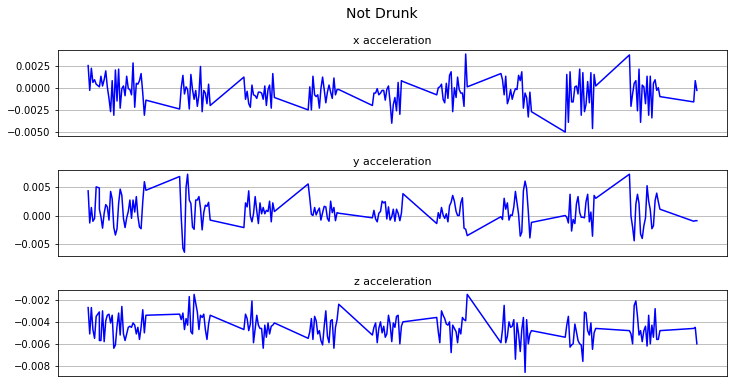

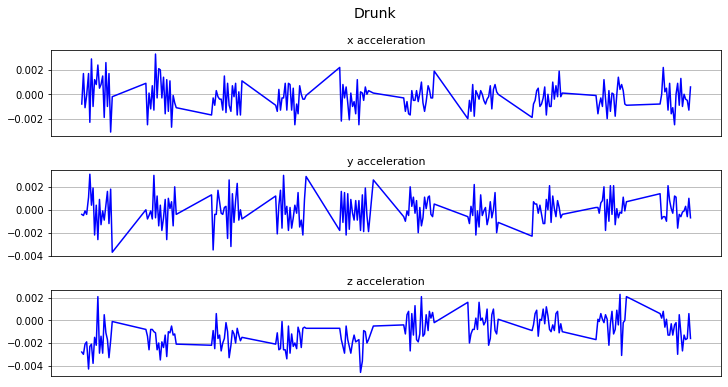

In [27]:
# frame size for sliding window
f = 20

tac_value = data['tac'].value_counts().index

# Create plot for both tac values using the above functions
for i in tac_value:
    df_plot = data[(data['tac'] == i)][:f*10]
    plot(df_plot, i)

### Label the Dataset

Drop time column

In [28]:
data.drop("acc_time", axis=1, inplace=True)
data.head()

,tac,x,y,z
0,0,0.0025,0.0043,-0.0027
1,0,-0.0003,-0.0013,-0.0051
2,0,0.0022,0.0014,-0.0027
3,0,0.0006,-0.001,-0.0047
4,0,0.0009,-0.0005,-0.0055


Add Label

In [29]:
l_e = LabelEncoder()
data['l'] = l_e.fit_transform(data['tac'])
data.head()

,tac,x,y,z,l
0,0,0.0025,0.0043,-0.0027,0
1,0,-0.0003,-0.0013,-0.0051,0
2,0,0.0022,0.0014,-0.0027,0
3,0,0.0006,-0.001,-0.0047,0
4,0,0.0009,-0.0005,-0.0055,0


### Split to X and y

In [30]:
X = data[['x', 'y', 'z']]
y = data['l']

In [31]:
X.shape, y.shape

((192784, 3), (192784,))

### Transfrorm the Dataset to match the input of Tensor

In [32]:
def func(df, fs, hs):
    
    frs = []
    ls = []
    feat = 3
    a = (len(df) - fs)

    for w in range(0, a , hs):
        
        x = df['x'].values[w: w + fs]
        y = df['y'].values[w: w + fs]
        z = df['z'].values[w: w + fs]
        
        l = stats.mode(df['l'][w: w + fs])[0][0]
        frs.append([x, y, z])
        ls.append(l)

    frs = np.asarray(frs).reshape(-1, fs, feat)
    ls = np.asarray(ls)

    return frs, ls

In [33]:
scaler = StandardScaler()

X2 = scaler.fit_transform(X)
scaled_X1 = pd.DataFrame(data = X2, columns = ['x', 'y', 'z'])
scaled_X1['l'] = y.values

s = 20
fs = s*10
hs = s*2

X2, y2 = func(scaled_X1, fs, hs)

In [34]:
X2.shape, y2.shape

((4815, 200, 3), (4815,))

## 2. Model Development

### Train - Test Split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = 0.2, random_state = 0, stratify = y2)

In [36]:
X_train.shape, X_test.shape

((3852, 200, 3), (963, 200, 3))

In [37]:
y_train.shape, y_test.shape

((3852,), (963,))

### I. Building a Convolutional Neural Network Model

Implementation of the final model (model with the best performance)

In [38]:
# filter 64, size 5, features 128

# Conv1D (1)
model = Sequential()
model.add(Conv1D(filters = 64, kernel_size = 5, activation = 'relu', input_shape = X_train[0].shape))


# Conv1D (2)
model.add(Conv1D(64, kernel_size = 5, activation='relu'))

# Drop out with drop out layer p = 0.5
model.add(Dropout(0.5))

# Max Pooling with pool size equal to 2
model.add(MaxPooling1D(pool_size=2))

# This layer flattens the resulting array to 1D array
model.add(Flatten())

# Fully connected layer with 128 features before the final output
model.add(Dense(254, activation='softmax'))

# We use the binary cross entropy as the loss function and Adam as the optimizer.
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 196, 64)           1024      
                                                                 
 conv1d_1 (Conv1D)           (None, 192, 64)           20544     
                                                                 
 dropout (Dropout)           (None, 192, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 96, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 254)               1560830   
                                                        

#### Training the CNN

In [39]:
history = model.fit(X_train, y_train, epochs = 10, batch_size = 20, validation_data= (X_test, y_test), verbose=1)

Epoch 1/10
193/193 [==============================] - 4s 20ms/step - loss: 0.8316 - accuracy: 0.6516 - val_loss: 0.5911 - val_accuracy: 0.7331
Epoch 2/10
193/193 [==============================] - 4s 20ms/step - loss: 0.4960 - accuracy: 0.7640 - val_loss: 0.4780 - val_accuracy: 0.8037
Epoch 3/10
193/193 [==============================] - 4s 19ms/step - loss: 0.3881 - accuracy: 0.8292 - val_loss: 0.3747 - val_accuracy: 0.8505
Epoch 4/10
193/193 [==============================] - 4s 20ms/step - loss: 0.3071 - accuracy: 0.8746 - val_loss: 0.3198 - val_accuracy: 0.8702
Epoch 5/10
193/193 [==============================] - 4s 22ms/step - loss: 0.2601 - accuracy: 0.8930 - val_loss: 0.2808 - val_accuracy: 0.9024
Epoch 6/10
193/193 [==============================] - 4s 22ms/step - loss: 0.2197 - accuracy: 0.9159 - val_loss: 0.2715 - val_accuracy: 0.8920
Epoch 7/10
193/193 [==============================] - 4s 22ms/step - loss: 0.2085 - accuracy: 0.9255 - val_loss: 0.2364 - val_accuracy: 0.9242

In [40]:
X_predict = model.predict(X_test) 
y_predict = np.argmax(X_predict,axis=1)

cn_matrix = confusion_matrix(y_test, y_predict)
#[[True Negative, False Positive]
#[False Negative, True Positive]]

cr = classification_report(y_test, y_predict)

print(cr)
print (cn_matrix)

31/31 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       482
           1       0.93      0.96      0.94       481

    accuracy                           0.94       963
   macro avg       0.94      0.94      0.94       963
weighted avg       0.94      0.94      0.94       963

[[449  33]
 [ 21 460]]


#### CNN Model Export

In [41]:
# saving the model to json format
json_string = model.to_json()
open('model.json', 'w').write(json_string)

#saving the weights of the model separately
model.save_weights('model.h5') 

### II. Building a Long Short Term Memory Model

In [42]:
#import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras import layers

# LSTM Layer
model2 = Sequential()
model2.add(layers.LSTM(64, input_shape = X_train[0].shape))

# Drop out with drop out layer p = 0.5
model2.add(Dropout(0.5))

# This layer flattens the resulting array to 1D array
model2.add(Flatten())

# Fully connected layer with 128 features before the final output
model2.add(Dense(128, activation='softmax'))

# We use the binary cross entropy as the loss function and Adam as the optimizer.
model2.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
Total params: 25,728
Trainable params: 25,728
Non-trainable params: 0
_________________________________________________________________


#### Training the LSTM

In [43]:
history2 = model2.fit(X_train, y_train, epochs = 10, batch_size = 20, validation_data= (X_test, y_test), verbose=1)

Epoch 1/10
193/193 [==============================] - 12s 55ms/step - loss: 1.4471 - accuracy: 0.4925 - val_loss: 0.6979 - val_accuracy: 0.5088
Epoch 2/10
193/193 [==============================] - 11s 56ms/step - loss: 0.7262 - accuracy: 0.5174 - val_loss: 0.6384 - val_accuracy: 0.7009
Epoch 3/10
193/193 [==============================] - 12s 62ms/step - loss: 0.6553 - accuracy: 0.6353 - val_loss: 0.6177 - val_accuracy: 0.7165
Epoch 4/10
193/193 [==============================] - 12s 63ms/step - loss: 0.6417 - accuracy: 0.6620 - val_loss: 0.6154 - val_accuracy: 0.6999
Epoch 5/10
193/193 [==============================] - 12s 64ms/step - loss: 0.6240 - accuracy: 0.6854 - val_loss: 0.6030 - val_accuracy: 0.6999
Epoch 6/10
193/193 [==============================] - 13s 68ms/step - loss: 0.6232 - accuracy: 0.6906 - val_loss: 0.5934 - val_accuracy: 0.7155
Epoch 7/10
193/193 [==============================] - 13s 66ms/step - loss: 0.6147 - accuracy: 0.7028 - val_loss: 0.5950 - val_accuracy:

## 3. Test using CNN

In this section we set up code for inference

### Test Data Preprocessing

We load a previously created .csv file of another "pid".

In [44]:
test = pd.read_csv("PC6771")
test = pd.DataFrame(test)
test.drop("Unnamed: 0", axis=1, inplace=True)

test.head()

,time,pid,x,y,z
0,1493735288409,PC6771,0.0040,-0.0113,0.0051
1,1493735288435,PC6771,0.0039,-0.0088,0.0171
2,1493735288460,PC6771,-0.0012,-0.0088,0.0172
3,1493735288485,PC6771,0.0033,-0.0048,0.0072
4,1493735288510,PC6771,0.0051,-0.0033,0.0135


Add seconds column

In [45]:
test['time_seconds'] = test['time'].apply(seconds)
test.head()

,time,pid,x,y,z,time_seconds
0,1493735288409,PC6771,0.0040,-0.0113,0.0051,1493735288
1,1493735288435,PC6771,0.0039,-0.0088,0.0171,1493735288
2,1493735288460,PC6771,-0.0012,-0.0088,0.0172,1493735288
3,1493735288485,PC6771,0.0033,-0.0048,0.0072,1493735288
4,1493735288510,PC6771,0.0051,-0.0033,0.0135,1493735288


Load the correspoding TAC .csv file

In [47]:
test_tac = pd.read_csv("PC6771_clean_TAC.csv")
test_tac = pd.DataFrame(test_tac)
test_tac.head()

,timestamp,TAC_Reading
0,1493717859,0.000043
1,1493720213,0.003820
2,1493720624,0.004772
3,1493721057,0.002101
4,1493721363,-0.002334


Combine the two dataframes (Accelerometer & TAC)

In [48]:
# Columns of the combined dataset
df1 = pd.DataFrame(columns=['pid', 'tac_start', 'tac_end', 'tac', 
                                  'acc_time', 'x', 'y', 'z', 'acc_seconds'])

In [49]:
tac_timestamp1 = test_tac['timestamp'].to_list() 
tac_reading1 = test_tac['TAC_Reading'].to_list() 

In [50]:
# Combine the two dataframes based on tac time intervals 

x1 = (len(tac_timestamp1) - 1)

for j in range(0, x1):
    
    start = tac_timestamp1[j] 
    end = tac_timestamp1[j+1] 
    
    try:
        # check if timestamp value exists in start-end range and 
        # use "cr" value for sublisting 
        cr = test['time_seconds'].between(start, end, inclusive='neither')
        cr.to_list().index(True)
        test_data2 = test
        test_data2['includes'] = cr
        test_data2 = test_data2.loc[test_data2['includes'] == True]

        test_data2 = test_data2.assign(tac_start_2 = start)
        test_data2 = test_data2.assign(tac_end_2 = end)
        test_data2 = test_data2.assign(tac = tac_reading1[j])
        
        # Create the combined dataset
        tdata2 = pd.DataFrame()
        tdata2['pid'] = test_data2['pid']
        tdata2['tac_start'] = test_data2['tac_start_2']
        tdata2['tac_end'] = test_data2['tac_start_2']
        tdata2['tac'] = test_data2['tac']
        tdata2['acc_time'] = test_data2['time']
        tdata2['x'] = test_data2['x']
        tdata2['y'] = test_data2['y']
        tdata2['z'] = test_data2['z']
        tdata2['acc_seconds'] = test_data2['time'].apply(seconds)
        
        df1 = pd.concat(objs=[df1, tdata2])

    except:
        pass
    
df1

,pid,tac_start,tac_end,tac,acc_time,x,y,z,acc_seconds
0,PC6771,1493734728,1493734728,0.059162,1493735288409,0.004,-0.0113,0.0051,1493735288
1,PC6771,1493734728,1493734728,0.059162,1493735288435,0.0039,-0.0088,0.0171,1493735288
2,PC6771,1493734728,1493734728,0.059162,1493735288460,-0.0012,-0.0088,0.0172,1493735288
3,PC6771,1493734728,1493734728,0.059162,1493735288485,0.0033,-0.0048,0.0072,1493735288
4,PC6771,1493734728,1493734728,0.059162,1493735288510,0.0051,-0.0033,0.0135,1493735288
...,...,...,...,...,...,...,...,...,...
1445075,PC6771,1493802165,1493802165,0.000882,1493803979885,-0.0004,-0.001,0.014,1493803979
1445076,PC6771,1493802165,1493802165,0.000882,1493803979910,-0.0105,0.0007,-0.0022,1493803979
1445077,PC6771,1493802165,1493802165,0.000882,1493803979935,0.0045,-0.0011,0.0273,1493803979
1445078,PC6771,1493802165,1493802165,0.000882,1493803979960,0.0009,-0.0004,0.0199,1493803979


Classify tac value

In [51]:
df1['tac'] = df1['tac'].apply(threshold)
df1.head()

,pid,tac_start,tac_end,tac,acc_time,x,y,z,acc_seconds
0,PC6771,1493734728,1493734728,0,1493735288409,0.004,-0.0113,0.0051,1493735288
1,PC6771,1493734728,1493734728,0,1493735288435,0.0039,-0.0088,0.0171,1493735288
2,PC6771,1493734728,1493734728,0,1493735288460,-0.0012,-0.0088,0.0172,1493735288
3,PC6771,1493734728,1493734728,0,1493735288485,0.0033,-0.0048,0.0072,1493735288
4,PC6771,1493734728,1493734728,0,1493735288510,0.0051,-0.0033,0.0135,1493735288


Drop irrelevant columns

In [52]:
df1.drop("pid", axis=1, inplace=True)
df1.drop("tac_start", axis=1, inplace=True)
df1.drop("tac_end", axis=1, inplace=True)
df1.drop("acc_time", axis=1, inplace=True)
df1.drop("acc_seconds", axis=1, inplace=True)
df1.drop("tac",axis=1, inplace = True)

df1.head()

,x,y,z
0,0.004,-0.0113,0.0051
1,0.0039,-0.0088,0.0171
2,-0.0012,-0.0088,0.0172
3,0.0033,-0.0048,0.0072
4,0.0051,-0.0033,0.0135


In [53]:
# Dataset rows must be multiple of 20
df1 = df1.head(400) 
df1.shape

(400, 3)

Transfrorm the Dataset to fit model input

In [54]:
def test_func(data, fs, hs):

    frs = []
    f = 3 #num of features
    a = (len(data) - fs)

    
    for j in range(0, a, hs):
        x = data['x'].values[j: j + fs]
        y = data['y'].values[j: j + fs]
        z = data['z'].values[j: j + fs]
        frs.append([x, y, z])

    # Bring the segments into a better shape
    frs = np.asarray(frs).reshape(-1, fs, f)

    return frs

In [55]:
fs, hs

(200, 40)

In [56]:
scaler = StandardScaler()

X_test = scaler.fit_transform(X)
scaled_X_test = pd.DataFrame(data = X_test, columns = ['x', 'y', 'z'])
X_t = test_func(scaled_X_test, fs, hs)

In [57]:
X_t.shape

(4815, 200, 3)

Restore the model from scratch

In [58]:
# Load the model from json
model = keras.models.model_from_json(open('model.json').read())

# Load the weights
model.load_weights('model.h5')

print("Model loaded successfully")

Model loaded successfully


Making Prediction

In [59]:
modelp = model.predict(X_t)
y_pr = np.argmax(modelp, axis=-1)
#print(y_pr)

tac_result = [y_pr[2]]

if tac_result == 0:
    print("Not Drunk")
else:
    print("Drunk")


151/151 [==============================] - 1s 5ms/step
Drunk
